In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from google.cloud import storage
from project_config import GCP_PROJECT_NAME

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

2023-10-19 21:18:52:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /data/tmp. Using root: /data/tmp/tmpjdvfix2r


### Configuration

In [4]:
from os.path import expanduser

from experiment_configs.unet_fs_config import unet_orig_config, unet_resblocks_config, resnet18_unet_config
from experiment_configs.satmae_ft_config import satmae_ft_doubleupsampling_config, satmae_ft_lineardecoder_config
from experiment_configs.resnetmoco_ft_config import resnet50_moco_ft_config
config = resnet50_moco_ft_config
#config.output_dir = expanduser("~/sandmining-watch/out/1009_resnet50_moco")

### Create Rastervision datasets

In [5]:
from torch.utils.data import ConcatDataset

from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, warn_if_nan_in_raw_raster
from utils.data_management import observation_factory

from project_config import is_training, is_validation


all_observations = observation_factory(gcp_client)
training_scenes = []
validation_scenes = []

for observation in all_observations:
    scene = observation_to_scene(config, observation)    
    training_scenes.append(scene)



training_datasets = [
    scene_to_training_ds(config, scene) for scene in training_scenes
]


2023-10-19 21:18:55:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s2_l1c/Godavari_EastGodavari_81-84_16-66_2022-06-01_s2_l1c.tif to /data/tmp/tmpjdvfix2r/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/s2_l1c/Godavari_EastGodavari_81-84_16-66_2022-06-01_s2_l1c.tif...
2023-10-19 21:18:57:rastervision.pipeline.file_system.utils: INFO - Downloading https://storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/annotations/Godavari_EastGodavari_81-84_16-66_2022-06-01_annotations.geojson to /data/tmp/tmpjdvfix2r/cache/http/storage.googleapis.com/sand_mining_test/labels/Godavari_EastGodavari_81-84_16-66_median/annotations/Godavari_EastGodavari_81-84_16-66_2022-06-01_annotations.geojson...


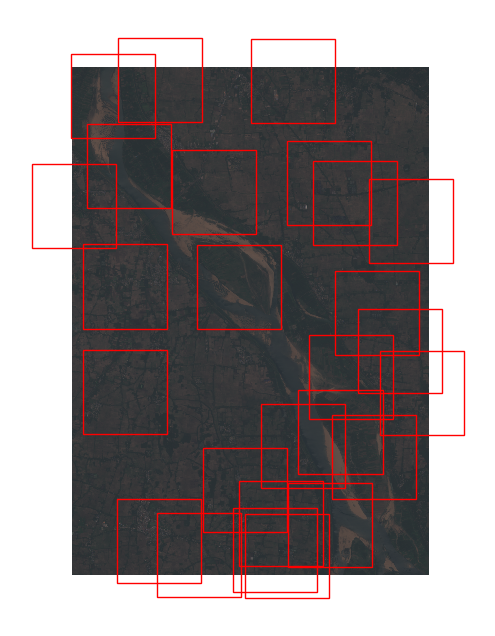

In [6]:
from utils.visualizing import Visualizer
visualizer = Visualizer(config.s2_channels)

train_ds = training_datasets[0]
windows = [train_ds.sample_window() for _ in range(train_ds.max_windows)]
visualizer.show_windows(
    train_ds.scene.raster_source.get_image_array(),
    windows
)

# val_ds = validation_datasets[0]
# visualizer.show_windows(
#     val_ds.scene.raster_source.get_image_array(),
#     val_ds.windows
# )


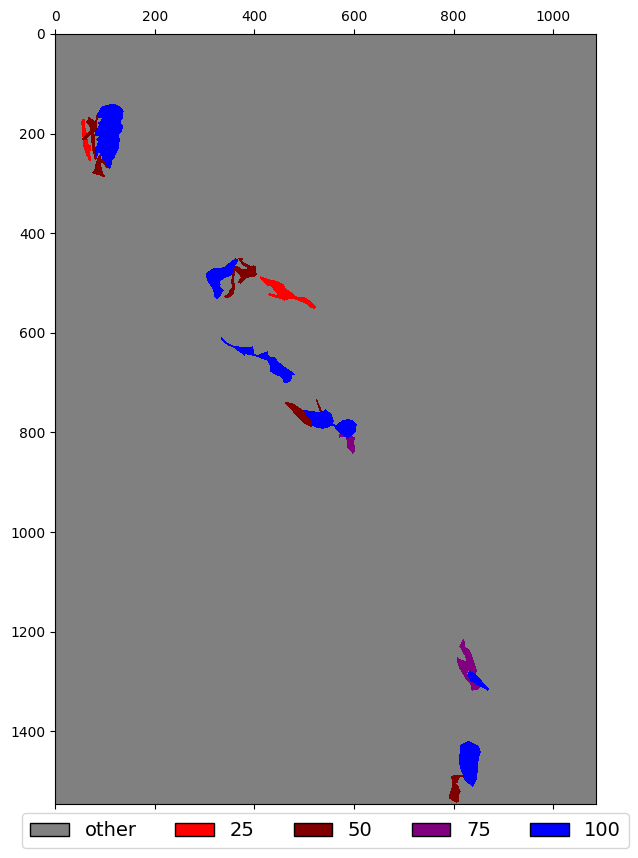

In [34]:
from utils.visualizing import show_labels
# show_labels(train_ds.scene.label_source.get_labels())
# train_ds.scene.label_source.get_label_arr()

show_labels(train_ds.scene.label_source.get_label_arr())

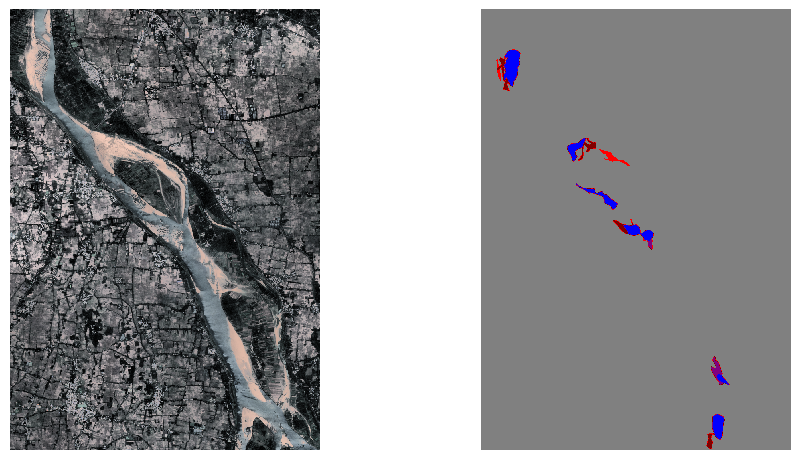

In [35]:
from utils.visualizing import show_rgb_with_labels

visualizer.show_rgb_with_labels(train_ds.scene.raster_source.get_image_array(), train_ds.scene.label_source.get_label_arr())

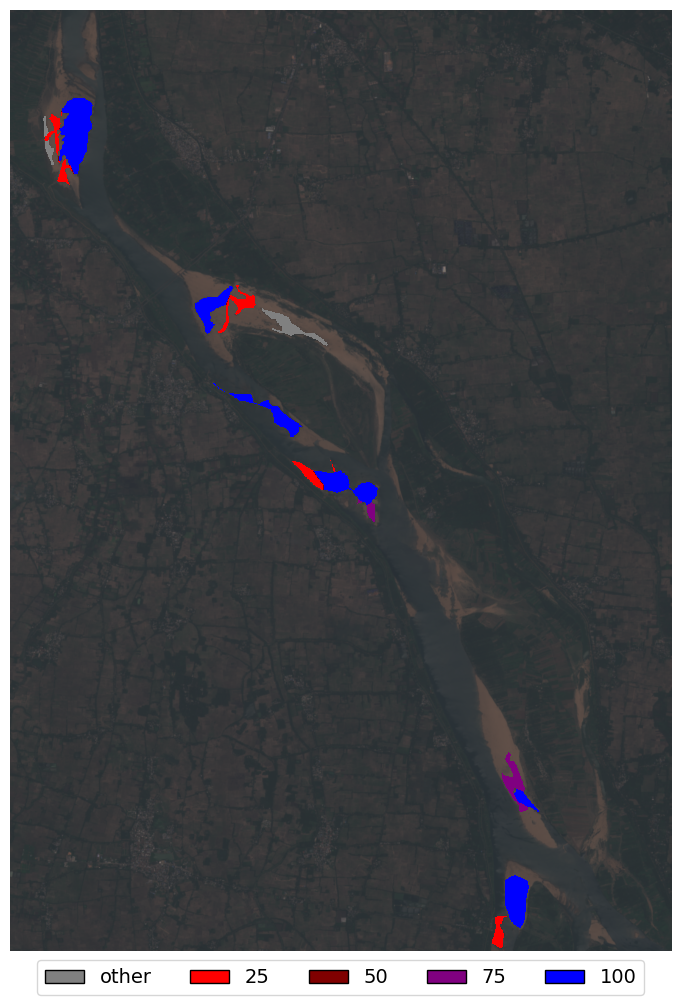

In [36]:
visualizer.show_rgb_overlay_labels(train_ds.scene.raster_source.get_image_array(), train_ds.scene.label_source.get_label_arr())

In [38]:
import numpy as np
np.max(train_ds.scene.label_source.get_label_arr())

1.0

# Train

In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
from models.model_factory import model_factory
from ml.optimizer_factory import optimizer_factory
from ml.custom_learner import learner_factory

_, _, n_channels = training_datasets[0].scene.raster_source.shape
model = model_factory(
    config,
    n_channels=n_channels,
)

optimizer = optimizer_factory(config, model)

learner = learner_factory(
    config=config,
    model=model,
    optimizer=optimizer,
    training_ds=train_dataset_merged,  # for development and debugging, use training_datasets[0] or similar to speed up
    validation_ds=val_dataset_merged,  # for development and debugging, use training_datasets[1] or similar to speed up
)
learner.log_data_stats()

#### Check GPU Activity

You can continuously monitor your GPU activity by using the command in the terminal


`watch -d -n 0.5 nvidia-smi`

In [ ]:
# Run this cell if you want to log the run to W&B. You might need to authenticate to W&B.
learner.initialize_wandb_run()

In [ ]:
learner.train(epochs=15)
learner.save_model_bundle()

## Evaluate 

Run inference on validation sites and log results to W&B

In [ ]:
learner.evaluate_and_log_to_wandb(validation_datasets)